# Dog Classifier(ResNet152)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import torch

import torchvision
from torchvision import datasets 
from torchvision import transforms 

from torch.utils.data import DataLoader 
from torch.utils.data import random_split

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy

In [3]:
!nvidia-smi

Tue Apr 18 20:41:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. 데이터 불러오기

In [5]:
data_dir = '/content/drive/MyDrive/project/'

In [70]:
transform = A.Compose([A.Resize(224, 224), A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.Normalize(), ToTensorV2()])

In [86]:
transform = transforms.Compose([transforms.Resize([224, 224]), 
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomVerticalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [87]:
imageset = datasets.ImageFolder(data_dir+ 'images/Images', transform = transform)

In [88]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [89]:
train_indices, test_indices = train_test_split(
                            range(len(imageset)),                        
                            stratify=imageset.targets,test_size= 0.2, random_state=42)

trainset = Subset(imageset, train_indices)
testset = Subset(imageset, test_indices)

train_indices_, valid_indices = train_test_split(
                            range(len(trainset)),                       
                            test_size= 0.2, random_state=42)

train_set = Subset(trainset, train_indices_)
valid_set = Subset(trainset, valid_indices)

print(type(train_set), len(train_set))
print(type(valid_set), len(valid_set))
print(type(testset), len(testset))

<class 'torch.utils.data.dataset.Subset'> 13171
<class 'torch.utils.data.dataset.Subset'> 3293
<class 'torch.utils.data.dataset.Subset'> 4116


## 2. 데이터 시각화

In [90]:
labels_map = {}
for i, name in enumerate(imageset.classes) :
    name=name[10:]
    labels_map[i]=name     
print(labels_map) 

{0: 'Chihuahua', 1: 'Japanese_spaniel', 2: 'Maltese_dog', 3: 'Pekinese', 4: 'Shih-Tzu', 5: 'Blenheim_spaniel', 6: 'papillon', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound', 10: 'basset', 11: 'beagle', 12: 'bloodhound', 13: 'bluetick', 14: 'black-and-tan_coonhound', 15: 'Walker_hound', 16: 'English_foxhound', 17: 'redbone', 18: 'borzoi', 19: 'Irish_wolfhound', 20: 'Italian_greyhound', 21: 'whippet', 22: 'Ibizan_hound', 23: 'Norwegian_elkhound', 24: 'otterhound', 25: 'Saluki', 26: 'Scottish_deerhound', 27: 'Weimaraner', 28: 'Staffordshire_bullterrier', 29: 'American_Staffordshire_terrier', 30: 'Bedlington_terrier', 31: 'Border_terrier', 32: 'Kerry_blue_terrier', 33: 'Irish_terrier', 34: 'Norfolk_terrier', 35: 'Norwich_terrier', 36: 'Yorkshire_terrier', 37: 'wire-haired_fox_terrier', 38: 'Lakeland_terrier', 39: 'Sealyham_terrier', 40: 'Airedale', 41: 'cairn', 42: 'Australian_terrier', 43: 'Dandie_Dinmont', 44: 'Boston_bull', 45: 'miniature_schnauzer', 46: 'giant_schnauzer'

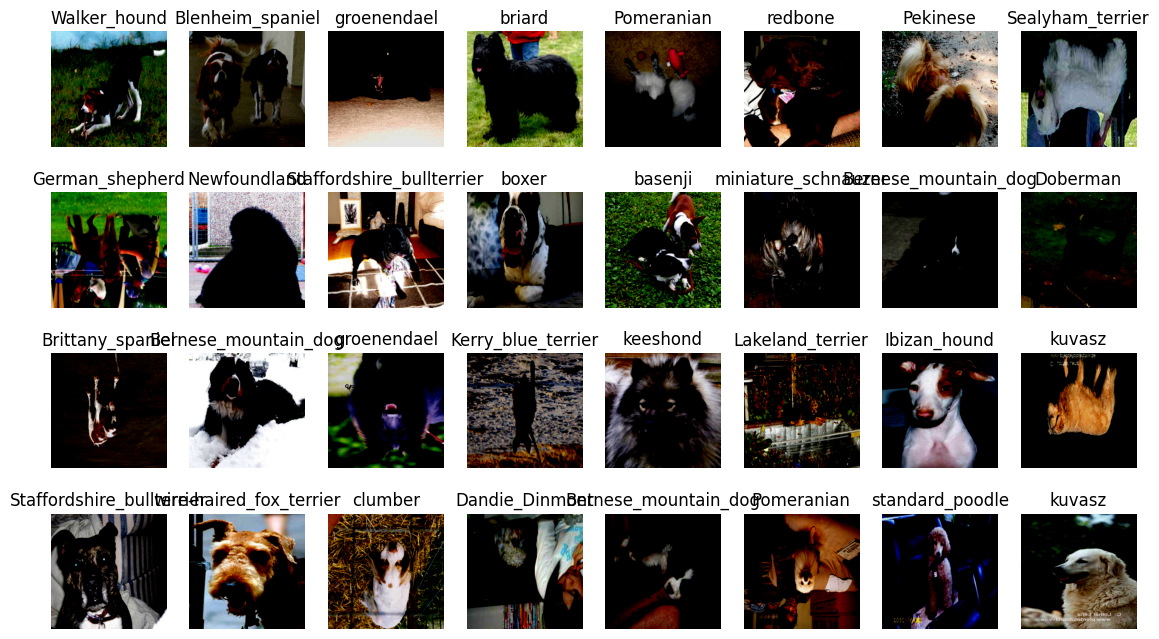

In [92]:
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
axes = axes.flatten()

for i in range(32):
  rand_i = np.random.randint(0, len(trainset))
  image, label= trainset[rand_i][0].permute(1, 2, 0), trainset[rand_i][1]
  axes[i].axis('off')
  axes[i].imshow(image)
  axes[i].set_title(labels_map[label])

## 3. 데이터 적재

In [93]:
batch_size = 16 
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True) 
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False) 
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [94]:
13171/batch_size, 3293/batch_size, 4116/batch_size

(823.1875, 205.8125, 257.25)

In [95]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 824
<class 'torch.utils.data.dataloader.DataLoader'> 206
<class 'torch.utils.data.dataloader.DataLoader'> 258


In [96]:
train_iter = iter(trainloader)
images, labels = next(train_iter)
images.size(), labels.size()

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

## 4. 모델 생성

In [97]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

In [99]:
import torchvision.models as models

# https://github.com/pytorch/vision/tree/6db1569c89094cf23f3bc41f79275c45e9fcb3f3/torchvision/models

model = models.resnet152(weights='ResNet152_Weights.IMAGENET1K_V2')

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:00<00:00, 274MB/s]


In [100]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [101]:
model.fc = nn.Linear(in_features=2048, out_features=120, bias=True)

In [102]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
out = model(images.to(device))
out.shape

torch.Size([16, 120])

In [104]:
for name, parameter in model.named_parameters():
  print(name, parameter.size())

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
layer1.0.bn3.weight torch.Size([256])
layer1.0.bn3.bias torch.Size([256])
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
layer1.0.downsample.1.weight torch.Size([256])
layer1.0.downsample.1.bias torch.Size([256])
layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
layer1.1.bn3.weight torch.Size([256])
layer1.1.bn3.bias torch.Size([256])
layer1.2.conv1.weight tor

## 5. 모델 컴파일 (손실함수, 옵티마이저 선택)

In [105]:
learning_rate = 0.0001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [106]:
from torchsummary import summary

In [107]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## 6. 모델 훈련

In [108]:
def validate(model, validloader, loss_fn):
  total = 0   
  correct = 0
  valid_loss = 0
  valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in validloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.size()[0], 784)

      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    valid_accuracy = correct / total
  
  return valid_loss, valid_accuracy

In [109]:
writer = SummaryWriter()

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
  steps = 0
  steps_per_epoch = len(trainloader) 
  min_loss = 1000000
  max_accuracy = 0
  trigger = 0
  patience = 7 

  for epoch in range(epochs):
    model.train() # 훈련 모드
    train_loss = 0
    for images, labels in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      steps += 1
      # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten !!
      # images.resize_(images.shape[0], 784) 

      # 2. 전방향(forward) 예측
      predict = model(images) # 예측 점수
      loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

      # 3. 역방향(backward) 오차(Gradient) 전파
      optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
      loss.backward() # 모델파리미터들의 Gradient 전파

      # 4. 경사 하강법으로 모델 파라미터 업데이트
      optimizer.step() # W <- W -lr*Gradient

      train_loss += loss.item()
      if (steps % steps_per_epoch) == 0 : 
        model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
        valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

        # tensorboard 시각화를 위한 로그 이벤트 등록
        writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
        writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
        writer.add_scalars('Train Loss and Valid Loss',
                          {'Train' : train_loss/len(trainloader),
                            'Valid' : valid_loss/len(validloader)}, epoch+1)
        writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)
        # -------------------------------------------

        print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
              'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
              'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
              'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
              )
        
        # Best model 저장    
        # option 1 : valid_loss 모니터링
        # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
        #   min_loss = valid_loss
        #   best_model_state = deepcopy(model.state_dict())          
        #   torch.save(best_model_state, 'best_checkpoint.pth')     
        
        # option 2 : valid_accuracy 모니터링      
        if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
          max_accuracy = valid_accuracy
          best_model_state = deepcopy(model.state_dict())          
          torch.save(best_model_state, '/content/drive/MyDrive/project/models/ResNet152/best_checkpoint.pth')  
        # -------------------------------------------

        # Early Stopping (조기 종료)
        if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
          trigger += 1
          print('trigger : ', trigger)
          if trigger > patience:
            print('Early Stopping !!!')
            print('Training loop is finished !!')
            writer.flush()   
            return
        else:
          trigger = 0
          min_loss = valid_loss
        # -------------------------------------------

        # Learning Rate Scheduler
        scheduler.step(valid_loss)
        # -------------------------------------------
        
  writer.flush()
  return  

In [ ]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)
writer.close()

Epoch : 1/55....... Train Loss : 1.846 Valid Loss : 0.791 Valid Accuracy : 0.763
Epoch : 2/55....... Train Loss : 0.782 Valid Loss : 0.760 Valid Accuracy : 0.773
Epoch : 3/55....... Train Loss : 0.550 Valid Loss : 0.701 Valid Accuracy : 0.792
Epoch : 4/55....... Train Loss : 0.427 Valid Loss : 0.746 Valid Accuracy : 0.781
trigger :  1
Epoch : 5/55....... Train Loss : 0.344 Valid Loss : 0.787 Valid Accuracy : 0.776
trigger :  2
Epoch : 6/55....... Train Loss : 0.286 Valid Loss : 0.806 Valid Accuracy : 0.783
trigger :  3
Epoch : 7/55....... Train Loss : 0.239 Valid Loss : 0.816 Valid Accuracy : 0.783
trigger :  4
Epoch : 8/55....... Train Loss : 0.221 Valid Loss : 0.917 Valid Accuracy : 0.759
trigger :  5
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch : 9/55....... Train Loss : 0.113 Valid Loss : 0.685 Valid Accuracy : 0.816
Epoch : 10/55....... Train Loss : 0.071 Valid Loss : 0.672 Valid Accuracy : 0.822
Epoch : 11/55....... Train Loss : 0.053 Valid Loss : 0.716 Val

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=runs

In [ ]:
# testloader에서 미니 배치 가져오기
test_iter = iter(testloader)
images, labels = next(test_iter)
images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

# random한 index로 이미지 한장 준비하기
rnd_idx = 1
print(images[rnd_idx].shape, labels[rnd_idx])

In [ ]:
images[rnd_idx].shape

In [ ]:
# not Flatten!
# flattend_img = images[rnd_idx].view(1, 784)

# 준비된 이미지로 예측하기
model.eval()
with torch.no_grad():
  logit = model(images[rnd_idx].unsqueeze(0)) # model.forward()에서는 배치가 적용된 4차원 입력 기대

pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx]) # True : 잘 예측

In [ ]:
print("pred:", pred, "labels:", labels[rnd_idx])
print(labels_map[pred.cpu().item()], labels_map[labels[rnd_idx].cpu().item()])
plt.imshow(images[rnd_idx].permute(1, 2, 0).cpu())

##8. 모델 평가

In [ ]:
def evaluation(model, testloader, loss_fn):
  total = 0   
  correct = 0
  test_loss = 0
  test_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
  with torch.no_grad():
    for images, labels in testloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
      # 0. Data를 GPU로 보내기
      images, labels = images.to(device), labels.to(device)

      # 1. 입력 데이터 준비
      # not Flatten
      # images.resize_(images.size()[0], 784)
      
      # 2. 전방향(Forward) 예측
      logit = model(images) # 예측 점수
      _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
      # preds = logit.max(dim=1)[1] 
      correct += int((preds == labels).sum()) # 배치치 중 맞은 것의 개수가 correct에 누적
      total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

      loss = loss_fn(logit, labels)
      test_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

    test_accuracy = correct / total
   
  print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
        'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

##9.모델 저장

In [ ]:
model.state_dict().keys()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/project/models/ResNet152/last_checkpoint.pth')

In [ ]:
# 시간이 흐른뒤 다시 모델 가져오기
last_state_dict = torch.load('/content/drive/MyDrive/project/models/ResNet152/last_checkpoint.pth')

In [ ]:
last_state_dict.keys()

In [ ]:
# 읽어들인 모델 파라미터는 모델 아키텍처에 연결을 시켜줘야 함
# load_state_dict() 사용
last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

In [ ]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

In [ ]:
# valid loss or accuracy 기준 best model
best_state_dict = torch.load('/content/drive/MyDrive/project/models/ResNet152/best_checkpoint.pth')
best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

In [ ]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)